In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder

accsTab = []
suggTab = [["numTot","numGood/numTot","avgSuggFollowed"]]
xygroups = []

groups = ['g1-new','g2-new','g3-new','g4-new','g5-new']

SEED = 1234
NRUNS = 10
TESTSIZE = 0.1

np.random.seed(SEED)

shuffles = model_selection.ShuffleSplit(n_splits=NRUNS, test_size=TESTSIZE, random_state=SEED)

for group in groups:
    # Read dataset
    df1 = pd.read_csv('threads-'+group+'-ng.txt',sep='\t')     # 2018 ng data
    df2 = pd.read_csv('threads-'+group+'-2020-ng.txt',sep='\t')   # 2020 ng data
    df = pd.concat([df1,df2]) 
    #df = df.drop(['FOLLOWERS'], axis=1)
    #df = df.drop(['MUSEUM'], axis=1)
    #df = df.drop(['PARTOFDAY'], axis=1)
    #df = df.drop(['ISRETWEET'], axis=1)
    df = df.drop(['ENG','LONG'], axis=1)
    #df = df.drop(['HASEMARK','HASNERMISC','DENSE','HASNERORG','HASNERLOC'], axis=1) # top 12
    df['FOLLOWERS']=df['FOLLOWERS']/1000
    df['MUSEUM']=df['MUSEUM'].astype('category').cat.codes  # label encoding
    df['PARTOFDAY']=df['PARTOFDAY'].astype('category').cat.codes  # label encoding
    #df = pd.get_dummies( df, columns = ['MUSEUM'] )  # one-hot-encoding
    #df = pd.get_dummies( df, columns = ['PARTOFDAY'] )  # one-hot-encoding
    # df description
    display(df.loc[:, df.columns != 'FORMULA'].describe())
    # print GOOD/BAD thresholds
    # print (df.NRETWEET.quantile([0.2,0.8]))
    # exclude central tweets
    df = df[ (df['NRETWEET'].rank(pct=True) < 0.2) | (df['NRETWEET'].rank(pct=True) > 0.8)] # deletes intermediate values
    #df = df[ (df['NRETWEET'].rank(pct=True) < 0.2) | ((df['NRETWEET'].rank(pct=True) > 0.4) & (df['NRETWEET'].rank(pct=True) < 0.6)) | (df['NRETWEET'].rank(pct=True) > 0.8)] # deletes two intermediate holes
        
    # target (y): 1 NRETWEET 2 NLIKE 3 NANS
    X, y = df.iloc[:,4:],df.iloc[:,1]   # X: prendo da col 5 a penultima
    y = np.where(df['NRETWEET'].rank(pct=True)>0.5, 'GOOD', 'BAD')  # y: 2 classi
    #y = np.where(df['NRETWEET'].rank(pct=True)>0.66, 'GOOD', np.where(df['NRETWEET'].rank(pct=True)>0.33, 'NO', 'BAD'))  # y: 3 classes
    #y = np.where(df['NRETWEET'].rank(pct=True)>0.8, 'GOOD', np.where(df['NRETWEET'].rank(pct=True)>0.2, 'NO', 'BAD'))  # y: 3 classes (unbalanced)
    y = LabelEncoder().fit(y).transform(y)    # label encoding per target, 'BAD'->0, 'GOOD'->1
    xygroups.append([X,y])
 
    # classification (xgb + sk classifiers)
    #cls = [KNeighborsClassifier(3),
         ##SVC(kernel="linear", C=0.025),
         ##SVC(gamma=2, C=1),
         ##GaussianProcessClassifier(1.0 * RBF(1.0)),
         #DecisionTreeClassifier(max_depth=5, random_state = np.random.seed(SEED)),
         #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1,random_state = np.random.seed(SEED)),
         ##MLPClassifier(alpha=1, max_iter=1000),
         #AdaBoostClassifier(),
         ##GaussianNB(),
         #xgb.XGBClassifier()]
    cls = [xgb.XGBClassifier()]
    if not len(accsTab):
        accsTab.append([cl.__class__.__name__ for cl in cls])
    accs = []
    for cl in cls:
        #print (cl.__class__.__name__)
        print (".", end = '')
        #cl.fit(X_train,y_train)
        #preds = cl.predict(X_test)
        #accuracy = accuracy_score(y_test, preds)
        results = model_selection.cross_val_score(cl, X, y, cv=shuffles, scoring='f1')
        #results = model_selection.cross_val_score(cl, X, y, cv=shuffles, scoring='accuracy') 
        accs.append("%.2f%%" % (results.mean()*100.0))
    accsTab.append(accs)
    
    # sugg accuracy test
    KNN = 5
    NUMSUGG = 3
    #print ("\nSugg test")
    X_clean = X.drop(['FOLLOWERS', 'MUSEUM', 'PARTOFDAY', 'ISRETWEET','LENGTH'], axis = 1) 
    X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=TESTSIZE, random_state=SEED)
    cl = xgb.XGBClassifier()
    cl.fit(X_train,y_train)
    explainer = shap.TreeExplainer(cl)
    X_test_predict = X_test.copy()
    X_test_predict["PREDICTION"] = cl.predict(X_test)
    X_test_predict_bad = X_test_predict[X_test_predict["PREDICTION"]==0].drop(['PREDICTION'], axis = 1)
    X_train_predict = X_train.copy()
    #X_train_predict["PREDICTION"] = y_train
    X_train_predict["PREDICTION"] = cl.predict(X_train)
    X_train_predict_good = X_train_predict[X_train_predict["PREDICTION"]==1].drop(['PREDICTION'], axis = 1) 
    ##print (X_test_predict_bad.shape[0])
    ##print (X_train_predict_good.shape[0])
    ##print (X_test_predict_bad)
    numGood = 0
    numTot = 0
    numSuggFollowed = []
    for index in range(X_test_predict_bad.shape[0]):     # for each bad tweet
        badTweet = X_test_predict_bad.iloc[[index],:].copy()
        #prediction = cl.predict(badTweet)
        ## print (prediction[0])  # predicted value
        ## print (y_test.flat[0]) # expected value
        shap_values = explainer.shap_values(badTweet)[0].tolist()
        #print ("Shap values: "+str(shap_values))
        minSuggIndexes = sorted(range(len(shap_values)), key=lambda k: shap_values[k])  # indexes of features in order of lowest shap value (highest negative impact)
        #print ("MinSuggIndexes: "+str(minSuggIndexes))
        # shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
        neigh = NearestNeighbors()
        neigh.fit(X_train_predict_good)
        knnIdxs = neigh.kneighbors(badTweet, KNN, return_distance=False).tolist()[0]
        ##print (knnIdxs)
        neighs = X_train_predict_good.iloc[ knnIdxs , : ]
        #print ("Bad tweet: \n"+str(badTweet))
        #print ("Nearest neighbors: \n"+str(neighs))
        suggFollowed = 0
        modifiedTweet = badTweet.copy()
        for suggIdx in minSuggIndexes:   # suggestion generation / tweet modification cycle
            startSugg = int(badTweet[badTweet.columns[suggIdx]])  # sugg start value
            targetSugg = int(round(neighs[neighs.columns[suggIdx]].mean()))   # sugg target value
            colNameSugg = badTweet.columns[suggIdx]  # sugg column name
            modSugg = targetSugg    # sugg modification to perform (same as target for boolean features)
            if startSugg == targetSugg:
                continue
            if targetSugg-startSugg>1:   # non-boolean and far from target feature
                modSugg = int(round((targetSugg+startSugg)/2))
            #print ("SUGG: "+colNameSugg+" from "+str(startSugg)+" to "+str(targetSugg)+" mod "+str(modSugg))
            modifiedTweet[modifiedTweet.columns[suggIdx]] = modSugg   # ok mod
            #rndSuggIdx = np.random.randint(0,len(badTweet.columns)-1)
            #rndModSugg = 1 if int(badTweet[badTweet.columns[rndSuggIdx]])==0 else 0
            #modifiedTweet[modifiedTweet.columns[rndSuggIdx]] = rndModSugg # random mod
            suggFollowed += 1
            if suggFollowed == NUMSUGG:
                break
        numSuggFollowed.append(suggFollowed)
        oldPrediction = cl.predict(badTweet)[0]
        newPrediction = cl.predict(modifiedTweet)[0]
        if newPrediction:
            numGood += 1
        numTot += 1
        #print ("Modified tweet: \n"+str(modifiedTweet))
        #print ("Old prediction: "+str(oldPrediction))
        #print ("New prediction: "+str(newPrediction))
        #break
    #print ("\nnumTot: "+str(numTot))
    #print ("numGood/numTot: "+str(numGood/numTot*100)+"%")
    #print ("avg numSuggFollowed: "+str(sum(numSuggFollowed)/len(numSuggFollowed)))
    suggTab.append([str(numTot), "%.2f"%(numGood/numTot*100), "%.2f"%(sum(numSuggFollowed)/len(numSuggFollowed))])

suggTab = list(map(list, zip(*suggTab)))
suggDF = pd.DataFrame(suggTab,columns=['TestSugg']+groups)
suggDF = suggDF.style.hide_index()
display (suggDF)

accsTab = list(map(list, zip(*accsTab)))
accsDF = pd.DataFrame(accsTab,columns=['Method']+groups)
accsDF = accsDF.style.hide_index()
accsDF

,NRETWEET,NLIKE,NANS,FOLLOWERS,MUSEUM,ISRETWEET,PARTOFDAY,HASEMARK,HASQMARK,HASNERPER,HASNERLOC,HASNERORG,HASNERMISC,NURLS,NIMG,NHASH,NMENTION,LENGTH,DENSE,SENT
count,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000
mean,67.479320,226.323822,3.647804,4594.911029,239.808753,0.118147,0.971465,0.224752,0.111895,0.607567,0.665117,0.349471,0.804104,0.803142,2.471946,0.957038,0.500962,228.558512,0.038474,0.665919
std,808.993444,2460.074945,28.712775,667.950023,112.578775,0.322808,1.016689,0.417452,0.315262,0.488332,0.471987,0.476841,0.396921,0.448441,1.305910,0.906967,0.954597,65.422246,0.192353,0.471706
min,0.000000,0.000000,0.000000,3501.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000
25%,9.000000,38.000000,0.000000,4364.000000,157.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,170.000000,0.000000,0.000000
50%,23.000000,83.000000,1.000000,4873.000000,235.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,238.000000,0.000000,1.000000
75%,47.000000,158.000000,3.000000,5384.000000,403.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,284.000000,0.000000,1.000000
max,47558.000000,147362.000000,1730.000000,5384.000000,486.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,33.000000,9.000000,13.000000,538.000000,1.000000,1.000000


.

,NRETWEET,NLIKE,NANS,FOLLOWERS,MUSEUM,ISRETWEET,PARTOFDAY,HASEMARK,HASQMARK,HASNERPER,HASNERLOC,HASNERORG,HASNERMISC,NURLS,NIMG,NHASH,NMENTION,LENGTH,DENSE,SENT
count,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000,11129.000000
mean,74.870878,210.243598,3.182496,1537.429508,806.705185,0.234972,0.930452,0.239285,0.137569,0.677869,0.613173,0.287088,0.753167,0.602300,2.557912,1.360949,0.487735,230.172253,0.073412,0.465990
std,288.725918,840.366141,12.227660,341.941073,436.051896,0.424000,0.956183,0.426666,0.344462,0.467314,0.487045,0.452423,0.431188,0.533711,1.642219,1.494991,0.918721,79.394990,0.260823,0.498864
min,0.000000,0.000000,0.000000,1071.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,17.000000,0.000000,0.000000
25%,11.000000,33.000000,0.000000,1255.000000,332.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,165.000000,0.000000,0.000000
50%,28.000000,81.000000,1.000000,1483.000000,917.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,240.000000,0.000000,0.000000
75%,74.000000,205.000000,3.000000,2024.000000,1271.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,293.000000,0.000000,1.000000
max,18092.000000,67216.000000,776.000000,2029.000000,1351.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,111.000000,18.000000,12.000000,874.000000,1.000000,1.000000


.

,NRETWEET,NLIKE,NANS,FOLLOWERS,MUSEUM,ISRETWEET,PARTOFDAY,HASEMARK,HASQMARK,HASNERPER,HASNERLOC,HASNERORG,HASNERMISC,NURLS,NIMG,NHASH,NMENTION,LENGTH,DENSE,SENT
count,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.00000,4940.000000
mean,21.896559,68.404858,1.025506,664.635628,216.008502,0.151619,0.830769,0.273684,0.189069,0.654656,0.623482,0.311741,0.818623,0.683806,2.512753,1.048785,0.555061,253.850607,0.03502,0.576518
std,34.978853,91.145523,2.441491,199.280083,80.370752,0.358688,0.991819,0.445894,0.391603,0.475528,0.484561,0.463251,0.385369,0.501890,1.106424,0.999620,0.862250,75.798293,0.18385,0.494160
min,0.000000,0.000000,0.000000,400.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,13.000000,0.00000,0.000000
25%,6.000000,23.000000,0.000000,400.000000,167.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,211.000000,0.00000,0.000000
50%,13.000000,44.000000,0.000000,706.000000,176.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,267.000000,0.00000,1.000000
75%,26.000000,82.000000,1.000000,884.000000,327.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,299.000000,0.00000,1.000000
max,950.000000,2011.000000,57.000000,884.000000,382.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,15.000000,11.000000,9.000000,663.000000,1.00000,1.000000


.

,NRETWEET,NLIKE,NANS,FOLLOWERS,MUSEUM,ISRETWEET,PARTOFDAY,HASEMARK,HASQMARK,HASNERPER,HASNERLOC,HASNERORG,HASNERMISC,NURLS,NIMG,NHASH,NMENTION,LENGTH,DENSE,SENT
count,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000
mean,11.540155,35.498536,0.635866,256.379280,358.189640,0.155530,0.934199,0.146366,0.075220,0.616266,0.643248,0.378389,0.818251,0.651521,2.597938,1.199949,0.561919,240.956981,0.072419,0.483518
std,112.113748,351.940152,3.643746,78.415881,97.904929,0.362432,0.966797,0.353496,0.263762,0.486325,0.479071,0.485016,0.385662,0.508565,1.323207,1.478498,1.161486,71.004421,0.259198,0.499760
min,0.000000,0.000000,0.000000,107.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.000000,0.000000,0.000000
25%,3.000000,8.000000,0.000000,243.000000,276.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,185.000000,0.000000,0.000000
50%,6.000000,16.000000,0.000000,262.000000,405.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,256.000000,0.000000,0.000000
75%,11.000000,32.000000,1.000000,278.000000,419.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,297.000000,0.000000,1.000000
max,9511.000000,28221.000000,262.000000,360.000000,483.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,17.000000,15.000000,16.000000,643.000000,1.000000,1.000000


.

,NRETWEET,NLIKE,NANS,FOLLOWERS,MUSEUM,ISRETWEET,PARTOFDAY,HASEMARK,HASQMARK,HASNERPER,HASNERLOC,HASNERORG,HASNERMISC,NURLS,NIMG,NHASH,NMENTION,LENGTH,DENSE,SENT
count,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000
mean,11.265155,31.867119,0.561591,42.711130,440.664040,0.250485,0.953322,0.304559,0.142580,0.621363,0.584748,0.282735,0.718841,0.543526,2.292192,2.058802,0.738846,230.239694,0.141368,0.213991
std,138.951418,414.863990,12.077730,20.763023,178.660534,0.433319,0.941803,0.460248,0.349665,0.485077,0.492795,0.450356,0.449592,0.556755,1.203438,2.045513,1.292894,80.784656,0.348421,0.410146
min,0.000000,0.000000,0.000000,13.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000,0.000000,0.000000
25%,1.000000,3.000000,0.000000,28.400000,290.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,165.000000,0.000000,0.000000
50%,3.000000,9.000000,0.000000,37.400000,429.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000,244.000000,0.000000,0.000000
75%,9.000000,27.000000,0.000000,64.000000,633.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,1.000000,295.000000,0.000000,0.000000
max,11710.000000,35051.000000,946.000000,68.000000,776.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,38.000000,18.000000,16.000000,1205.000000,1.000000,1.000000


.

TestSugg,g1-new,g2-new,g3-new,g4-new,g5-new
numTot,103,202,104,201,156
numGood/numTot,76.70,78.22,78.85,91.54,95.51
avgSuggFollowed,1.74,1.96,1.81,1.56,2.08


Method,g1-new,g2-new,g3-new,g4-new,g5-new
XGBClassifier,86.85%,92.01%,78.05%,69.63%,92.74%


In [3]:
# SHAP

# load JS visualization code to notebook
shap.initjs()

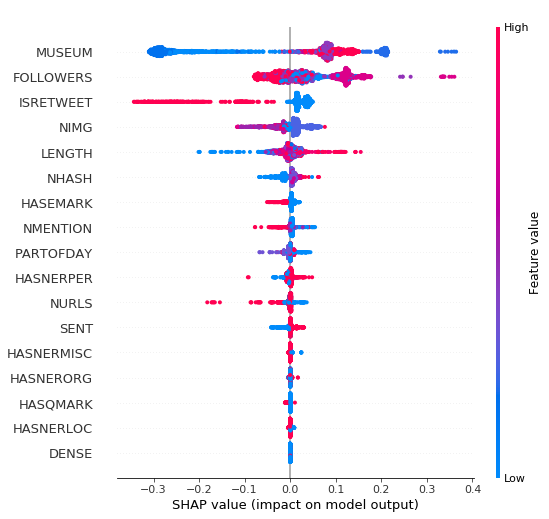

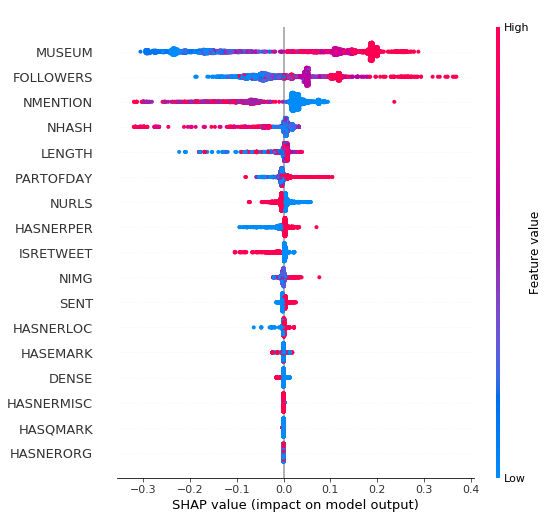

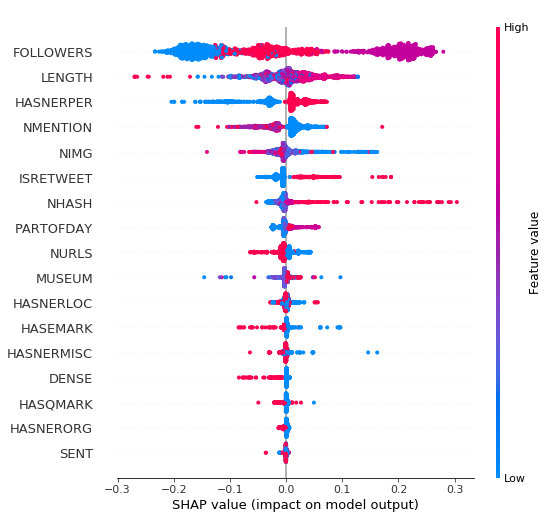

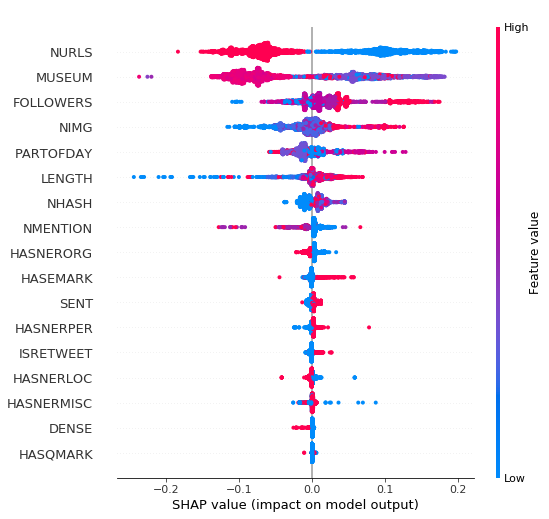

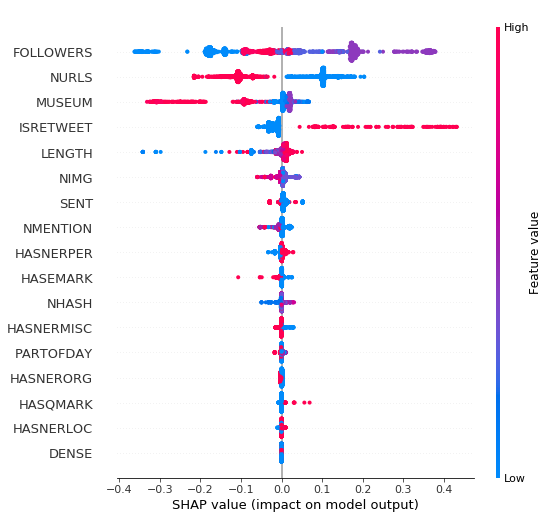

In [4]:
# 4 - summarize the effects of all the features
for xy in xygroups:
    X = xy[0]
    y = xy[1]
    model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X)

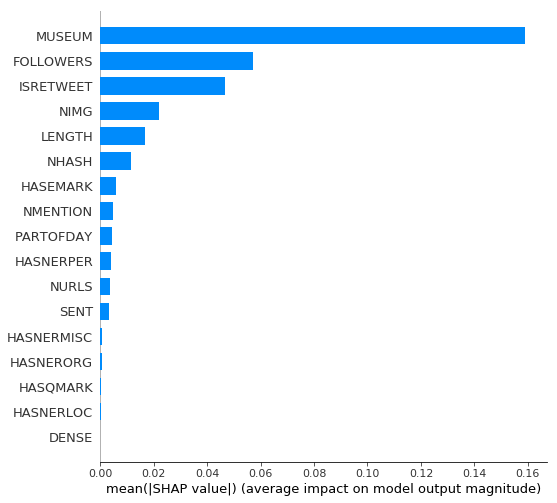

0     0.057254
1     0.159155
2     0.046737
3     0.004465
4     0.005766
5     0.000438
6     0.004083
7     0.000406
8     0.000462
9     0.000583
10    0.003598
11    0.021909
12    0.011541
13    0.004918
14    0.016694
15    0.000000
16    0.003316
dtype: float32


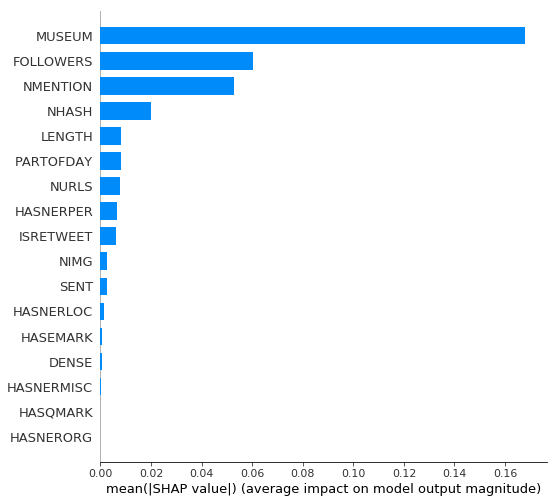

0     0.060212
1     0.168061
2     0.006039
3     0.008022
4     0.000811
5     0.000055
6     0.006626
7     0.001314
8     0.000008
9     0.000079
10    0.007637
11    0.002697
12    0.020177
13    0.053036
14    0.008311
15    0.000677
16    0.002635
dtype: float32


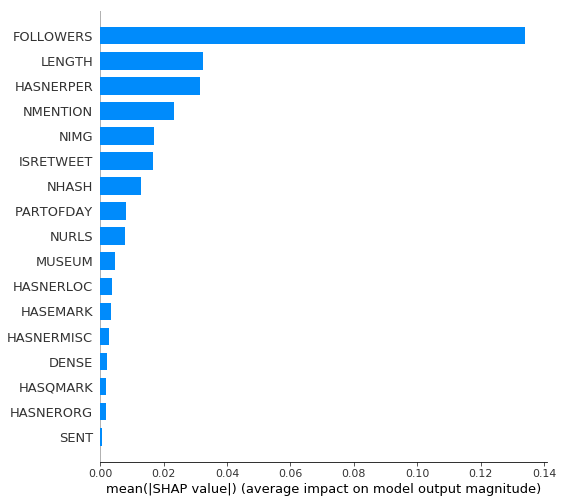

0     0.134172
1     0.004508
2     0.016711
3     0.008174
4     0.003248
5     0.001808
6     0.031380
7     0.003756
8     0.001762
9     0.002591
10    0.007906
11    0.016890
12    0.012843
13    0.023235
14    0.032523
15    0.002259
16    0.000651
dtype: float32


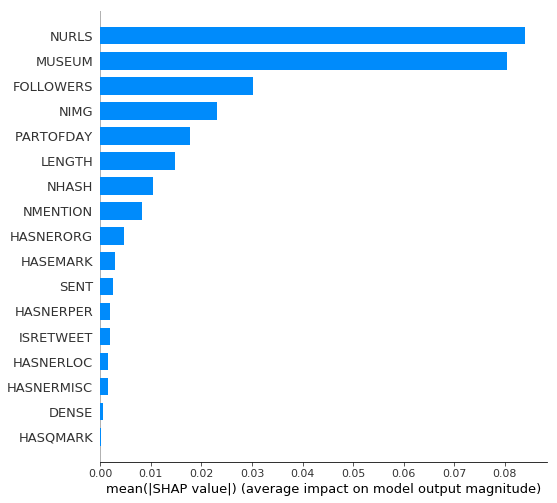

0     0.030226
1     0.080479
2     0.001986
3     0.017836
4     0.002951
5     0.000096
6     0.002011
7     0.001485
8     0.004740
9     0.001468
10    0.084104
11    0.023047
12    0.010324
13    0.008181
14    0.014816
15    0.000562
16    0.002476
dtype: float32


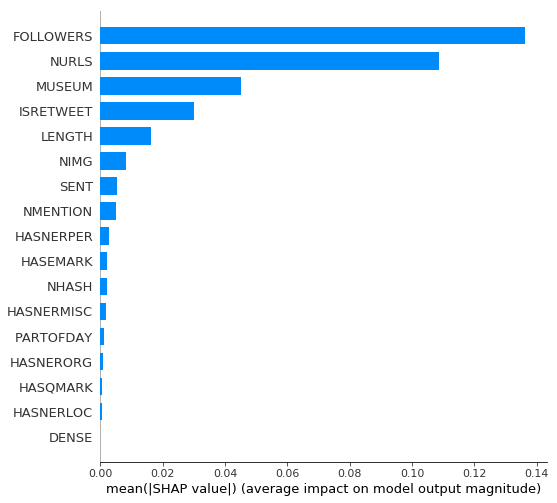

0     0.136369
1     0.045066
2     0.029894
3     0.001187
4     0.002019
5     0.000589
6     0.002630
7     0.000475
8     0.000982
9     0.001668
10    0.108749
11    0.008078
12    0.001988
13    0.005172
14    0.016393
15    0.000000
16    0.005364
dtype: float32


In [5]:
# 5 - summarize bar plot
for xy in xygroups:
    X = xy[0]
    y = xy[1]
    model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)
    #print (model.get_score(importance_type='gain'))
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, plot_type="bar")
    df_shap_values = pd.DataFrame(data=shap_values).apply(abs).mean(axis = 0) 
    print (df_shap_values)

In [6]:
#xgboost feature importance
imp=[]
i=1
for xy in xygroups:
    X = xy[0]
    y = xy[1]
    model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)
    d = model.get_score(importance_type='gain')
    sv = pd.DataFrame([d], columns=d.keys(), index=['Group_'+str(i)])
    imp.append(sv)
    #sv = sv.sort_values(by=[0],axis=1,ascending=False)
    i=i+1
sv = pd.concat(imp,sort=False)
display(sv)

,MUSEUM,FOLLOWERS,LENGTH,NHASH,SENT,HASEMARK,HASNERORG,HASNERPER,ISRETWEET,NIMG,NURLS,HASQMARK,NMENTION,PARTOFDAY,HASNERMISC,HASNERLOC,DENSE
Group_1,22.124746,2.575170,1.258528,1.176954,0.707673,1.134723,0.407659,0.818320,31.042444,2.174189,1.542545,0.898732,0.594804,1.035222,1.542064,0.817364,NaN
Group_2,20.257666,3.777241,1.143194,7.908074,0.652995,0.804169,0.792065,1.420549,2.526722,0.715135,1.064101,0.240258,7.857463,2.937416,0.956933,0.422363,0.676201
Group_3,0.678107,24.615127,1.229060,2.156288,0.733494,0.971985,0.849743,3.910152,1.643639,1.251968,1.591142,0.447101,1.138377,1.970731,0.820777,0.617136,1.053271
Group_4,3.768235,4.040234,1.455849,1.159947,1.386924,0.866166,0.766316,0.624077,1.188343,2.493472,20.271365,0.659825,1.154783,1.731957,0.879275,0.559846,1.366161
Group_5,5.226553,9.919984,1.587304,1.094880,3.721459,0.290490,0.226943,0.826642,12.017791,3.837207,92.208124,0.335823,1.406661,1.286818,0.811895,0.666968,NaN
